In [3]:
#!pip install yfinance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from scipy.stats import norm
import requests
from io import StringIO
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
import refinitiv.dataplatform as rdp
%run ../credentials.ipynb

In [3]:
session = rdp.open_platform_session(
    APP_KEY,
    rdp.GrantPassword(
        username = RDP_LOGIN,
        password = RDP_PASSWORD
    )
)

ERROR!!! Failed to request a new token......
         Token requested error b'{"error":"server_error"  ,"error_description":"Authentication Failed" } '
ERROR!!! response 500 while requesting URL('https://api.refinitiv.com/auth/oauth2/v1/token').
      {"error":"server_error"  ,"error_description":"Authentication Failed" } 
ERROR!!! authentication handler raise an exception.
HTTPStatusError("Server error '500 Internal Server Error' for url 'https://api.refinitiv.com/auth/oauth2/v1/token'\nFor more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/500")


PlatformSessionError: Error code -1 | ERROR!!! response 500 while requesting URL('https://api.refinitiv.com/auth/oauth2/v1/token').
      {"error":"server_error"  ,"error_description":"Authentication Failed" } 

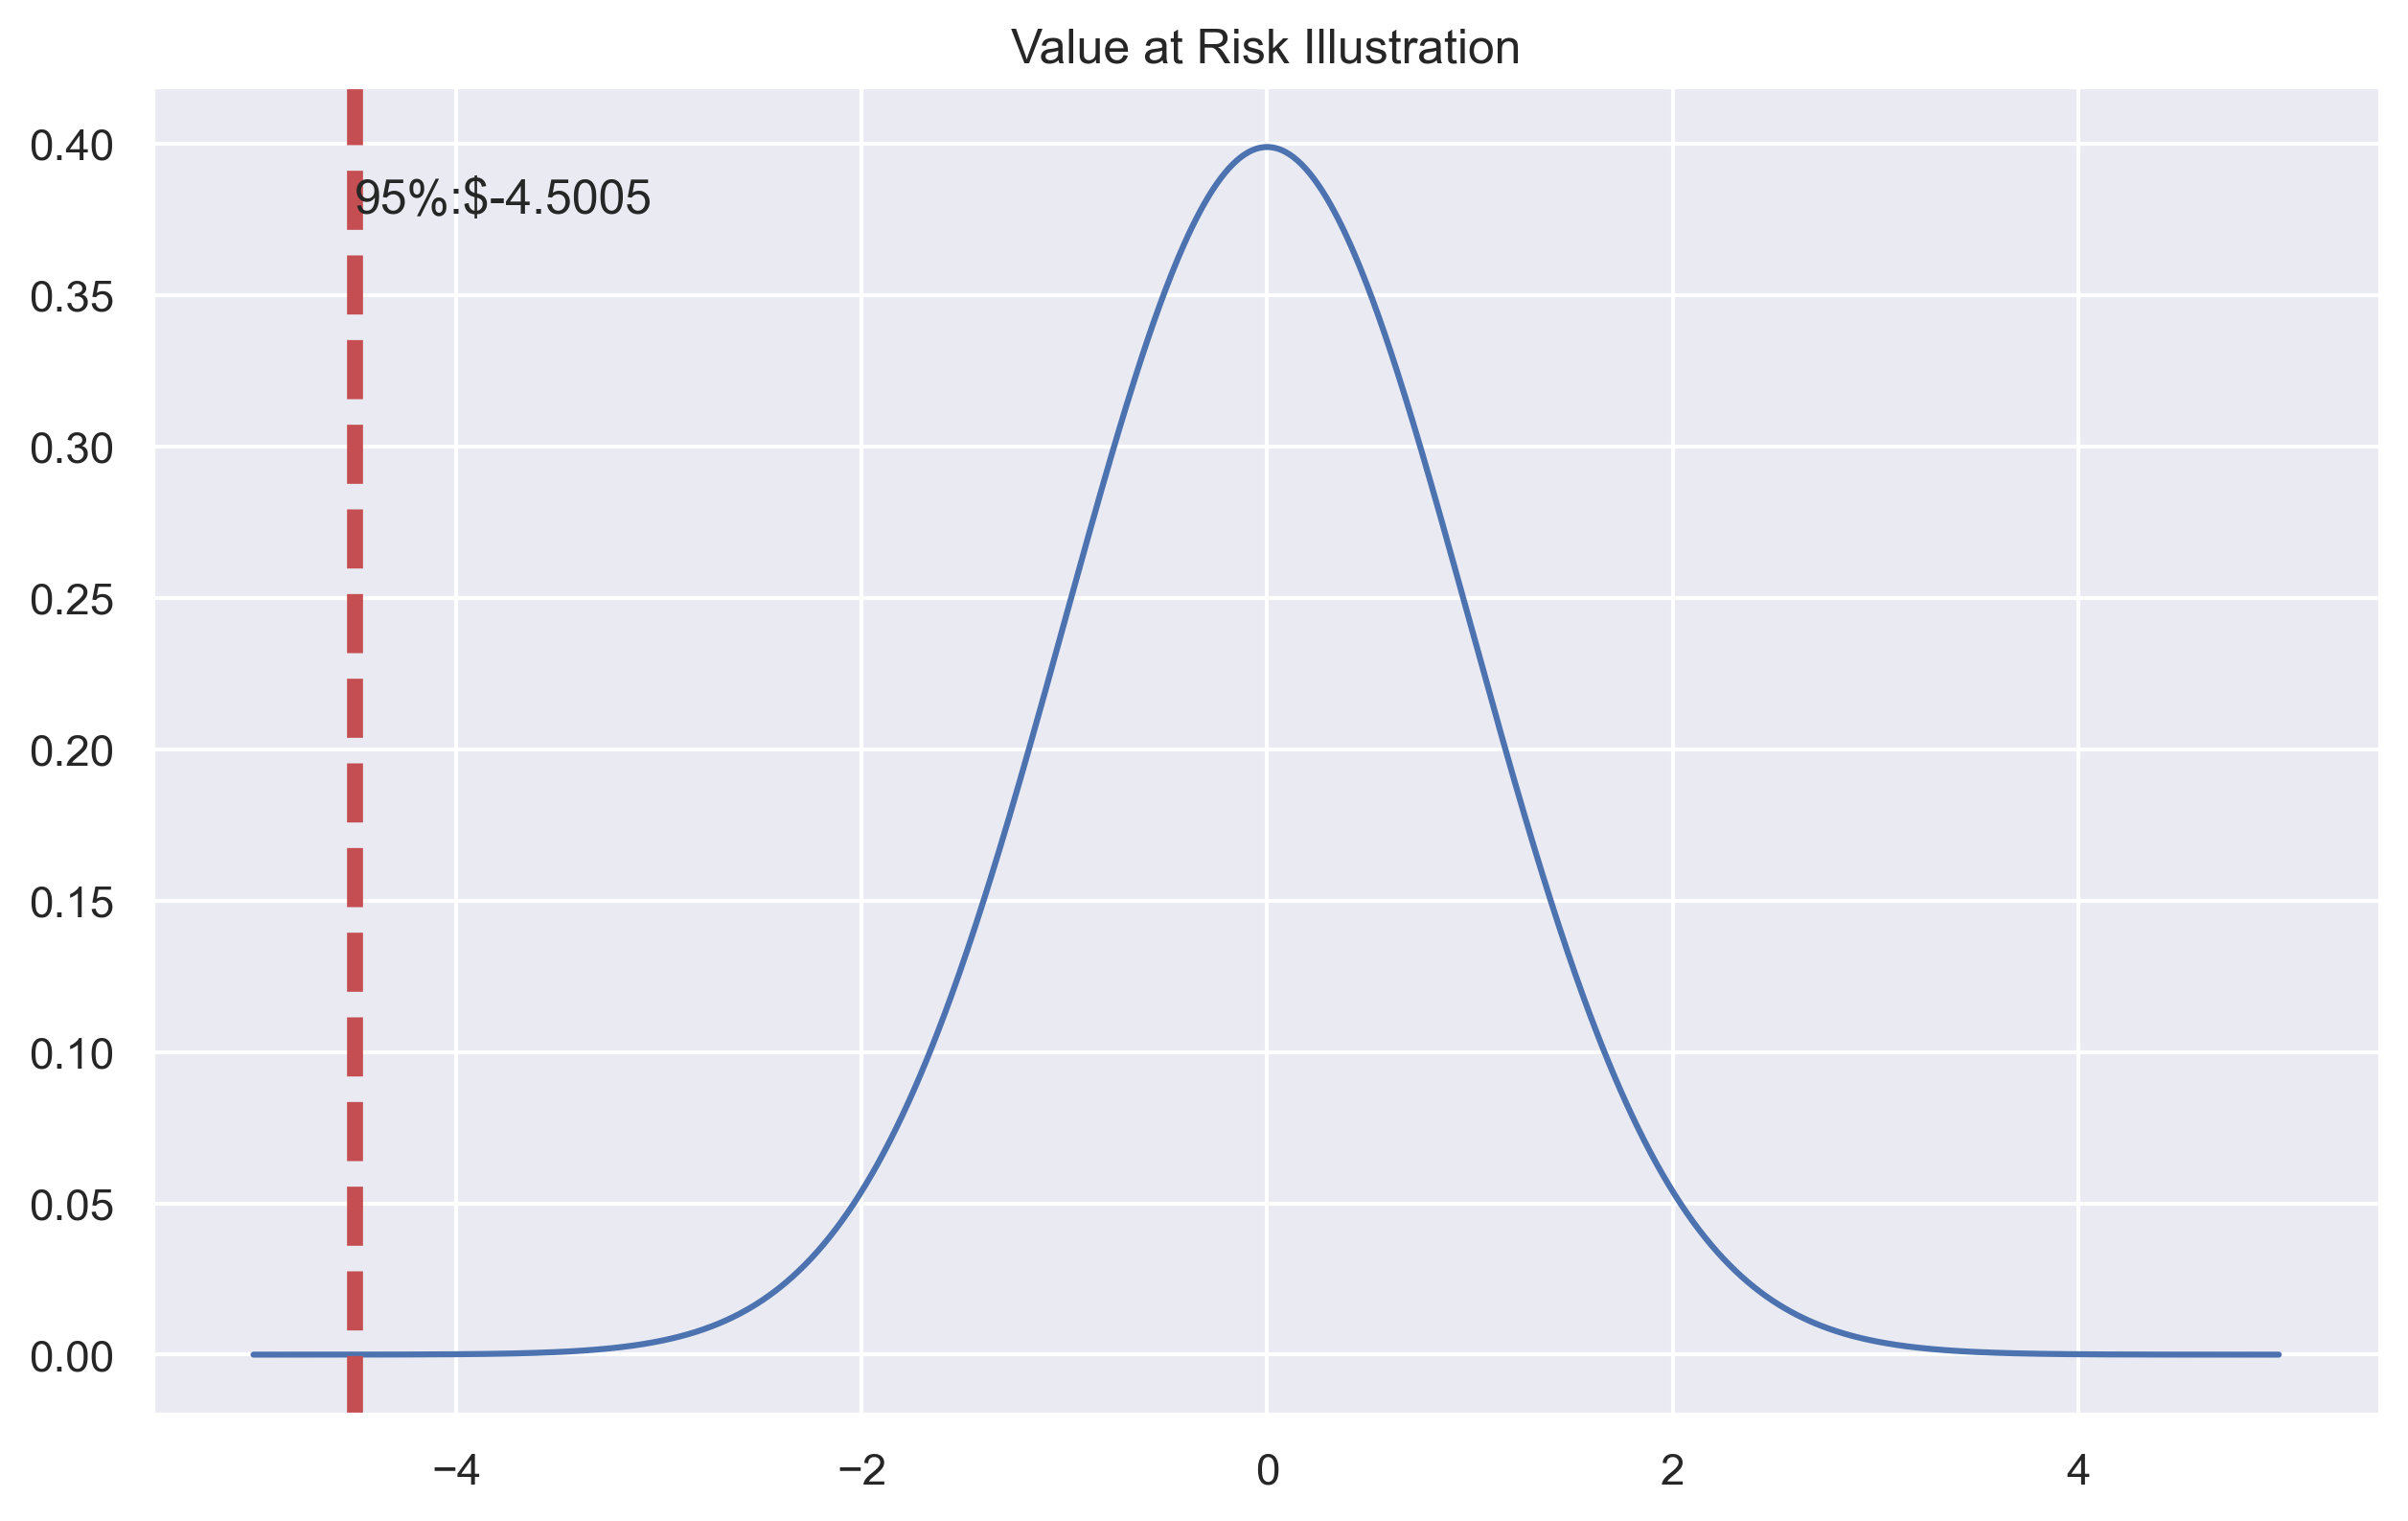

In [7]:
mean = 0
std_dev = 1
x = np.arange(-5, 5, 0.01)
y = norm.pdf(x, mean, std_dev)
pdf = plt.plot(x, y)
min_ylim, max_ylim = plt.ylim()
plt.text(np.percentile(x, 5), max_ylim * 0.9, '95%:${:.4f}'
         .format(np.percentile(x, 5)))
plt.axvline(np.percentile(x, 5), color='r', linestyle='dashed',
            linewidth=4)
plt.title('Value at Risk Illustration')
plt.show()

In [5]:
from datetime import datetime, timedelta
today = datetime.today()
past = today - timedelta(days=(365))
print(today, past)
stocks = ek.get_timeseries(["IBM", "MSFT.O", "NVDA.O"], start_date = past, end_date = today, fields='CLOSE', interval="daily")
stocks

2023-04-13 18:43:22.084660 2022-04-13 18:43:22.084660


CLOSE,IBM,MSFT.O,NVDA.O
Date,,,
2022-04-14,126.56,279.83,212.58
2022-04-18,126.17,280.52,217.83
2022-04-19,129.15,285.3,221.98
2022-04-20,138.32,286.36,214.82
2022-04-21,139.85,280.81,201.83
...,...,...,...
2023-04-06,130.5,291.6,270.37
2023-04-10,131.03,289.39,275.79
2023-04-11,130.42,282.83,271.69


In [6]:
## Saltar
def getDailyData(symbol):
        parameters = {'function': 'TIME_SERIES_DAILY_ADJUSTED', 
                      'symbol': symbol,
                       'outputsize':'full',
                       'datatype': 'csv', 
                       'apikey': 'insert your api key here'}

        response = requests.get('https://www.alphavantage.co/query',
                                params=parameters)

        csvText = StringIO(response.text)
        data = pd.read_csv(csvText, index_col='timestamp')
        return data

In [7]:
## Saltar
symbols = ["IBM", "MSFT", "INTC"]
stock3 = []
for symbol in symbols:
    stock3.append(getDailyData(symbol)[::-1]['close']
                  ['2020-01-01': '2020-12-31'])
stocks = pd.DataFrame(stock3).T
stocks.columns = symbols

In [8]:
## Saltar
stocks.head()

,IBM,MSFT,INTC
timestamp,,,
2020-01-02,135.42,160.62,60.84
2020-01-03,134.34,158.62,60.10
2020-01-06,134.10,159.03,59.93
2020-01-07,134.19,157.58,58.93
2020-01-08,135.31,160.09,58.97


## Variance-Covariance Method

In [6]:
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna()
stocks_returns

CLOSE,IBM,MSFT.O,NVDA.O
Date,,,
2022-04-18,-0.003086,0.002463,0.024397
2022-04-19,0.023344,0.016896,0.018872
2022-04-20,0.068595,0.003709,-0.032787
2022-04-21,0.011001,-0.019571,-0.062375
2022-04-22,-0.011507,-0.024441,-0.033657
...,...,...,...
2023-04-06,-0.012489,0.025212,0.005787
2023-04-10,0.004053,-0.007608,0.019848
2023-04-11,-0.004666,-0.022929,-0.014978


In [7]:
stocks_returns_mean = stocks_returns.mean()
weights  = np.random.random(len(stocks_returns.columns))
weights /= np.sum(weights)
cov_var = stocks_returns.cov()
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))

In [15]:
#stocks_returns_mean
#weights 
#cov_var
port_std 

0.02203729470271591

In [24]:
weights = [.2,.3,.4]

array([0.37394996, 0.21452257, 0.41152747])

In [13]:
#posiciones = ([12000, 1500, 300, 600, 234])
#precios = [12.3, 324, 243,23 ]
#valor_total = precios * posiciones = [144123, 5423]
#valor_portafolios = sum(valor_total)
#weights = array([0.15892504, 0.19353163, 0.64754333])

TypeError: can't multiply sequence by non-int of type 'list'

In [8]:
stocks_returns_mean = stocks_returns.mean()
stocks_returns_mean

CLOSE
IBM       0.000042
MSFT.O    0.000141
NVDA.O    0.000880
dtype: float64

In [13]:
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))

In [9]:
port_std

0.02203729470271591

In [38]:
1e6

1000000.0

In [16]:
initial_investment = 1e6
conf_level = 0.95

In [19]:
alpha = norm.ppf(.05, stocks_returns_mean, port_std)

In [20]:
alpha

array([-0.03620583, -0.03610697, -0.03536855])

In [21]:
stocks.columns

Index(['IBM', 'MSFT.O', 'NVDA.O'], dtype='object', name='CLOSE')

In [22]:
len(stocks.columns)

3

In [23]:
for i, j in zip(stocks.columns, range(len(stocks.columns))):
    VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
    print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))

Parametric VaR result for IBM is 36205.82610965776 
Parametric VaR result for MSFT.O is 36106.972430560854 
Parametric VaR result for NVDA.O is 35368.54887565016 


In [25]:
for i, j in zip(stocks.columns, range(len(stocks.columns))):
        VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
        print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))

Parametric VaR result for IBM is 36205.82610965776 
Parametric VaR result for MSFT.O is 36106.972430560854 
Parametric VaR result for NVDA.O is 35368.54887565016 


In [26]:
def VaR_parametric(initial_investment, conf_level):
    alpha = norm.ppf(1 - conf_level, stocks_returns_mean, port_std)
    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
        print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))
    VaR_param = (initial_investment - initial_investment * (1 + alpha))
    print('--' * 25)
    return VaR_param

In [27]:
VaR_param = VaR_parametric(initial_investment, conf_level)
VaR_param

Parametric VaR result for IBM is 36205.82610965776 
Parametric VaR result for MSFT.O is 36106.972430560854 
Parametric VaR result for NVDA.O is 35368.54887565016 
--------------------------------------------------


array([36205.82610966, 36106.97243056, 35368.54887565])

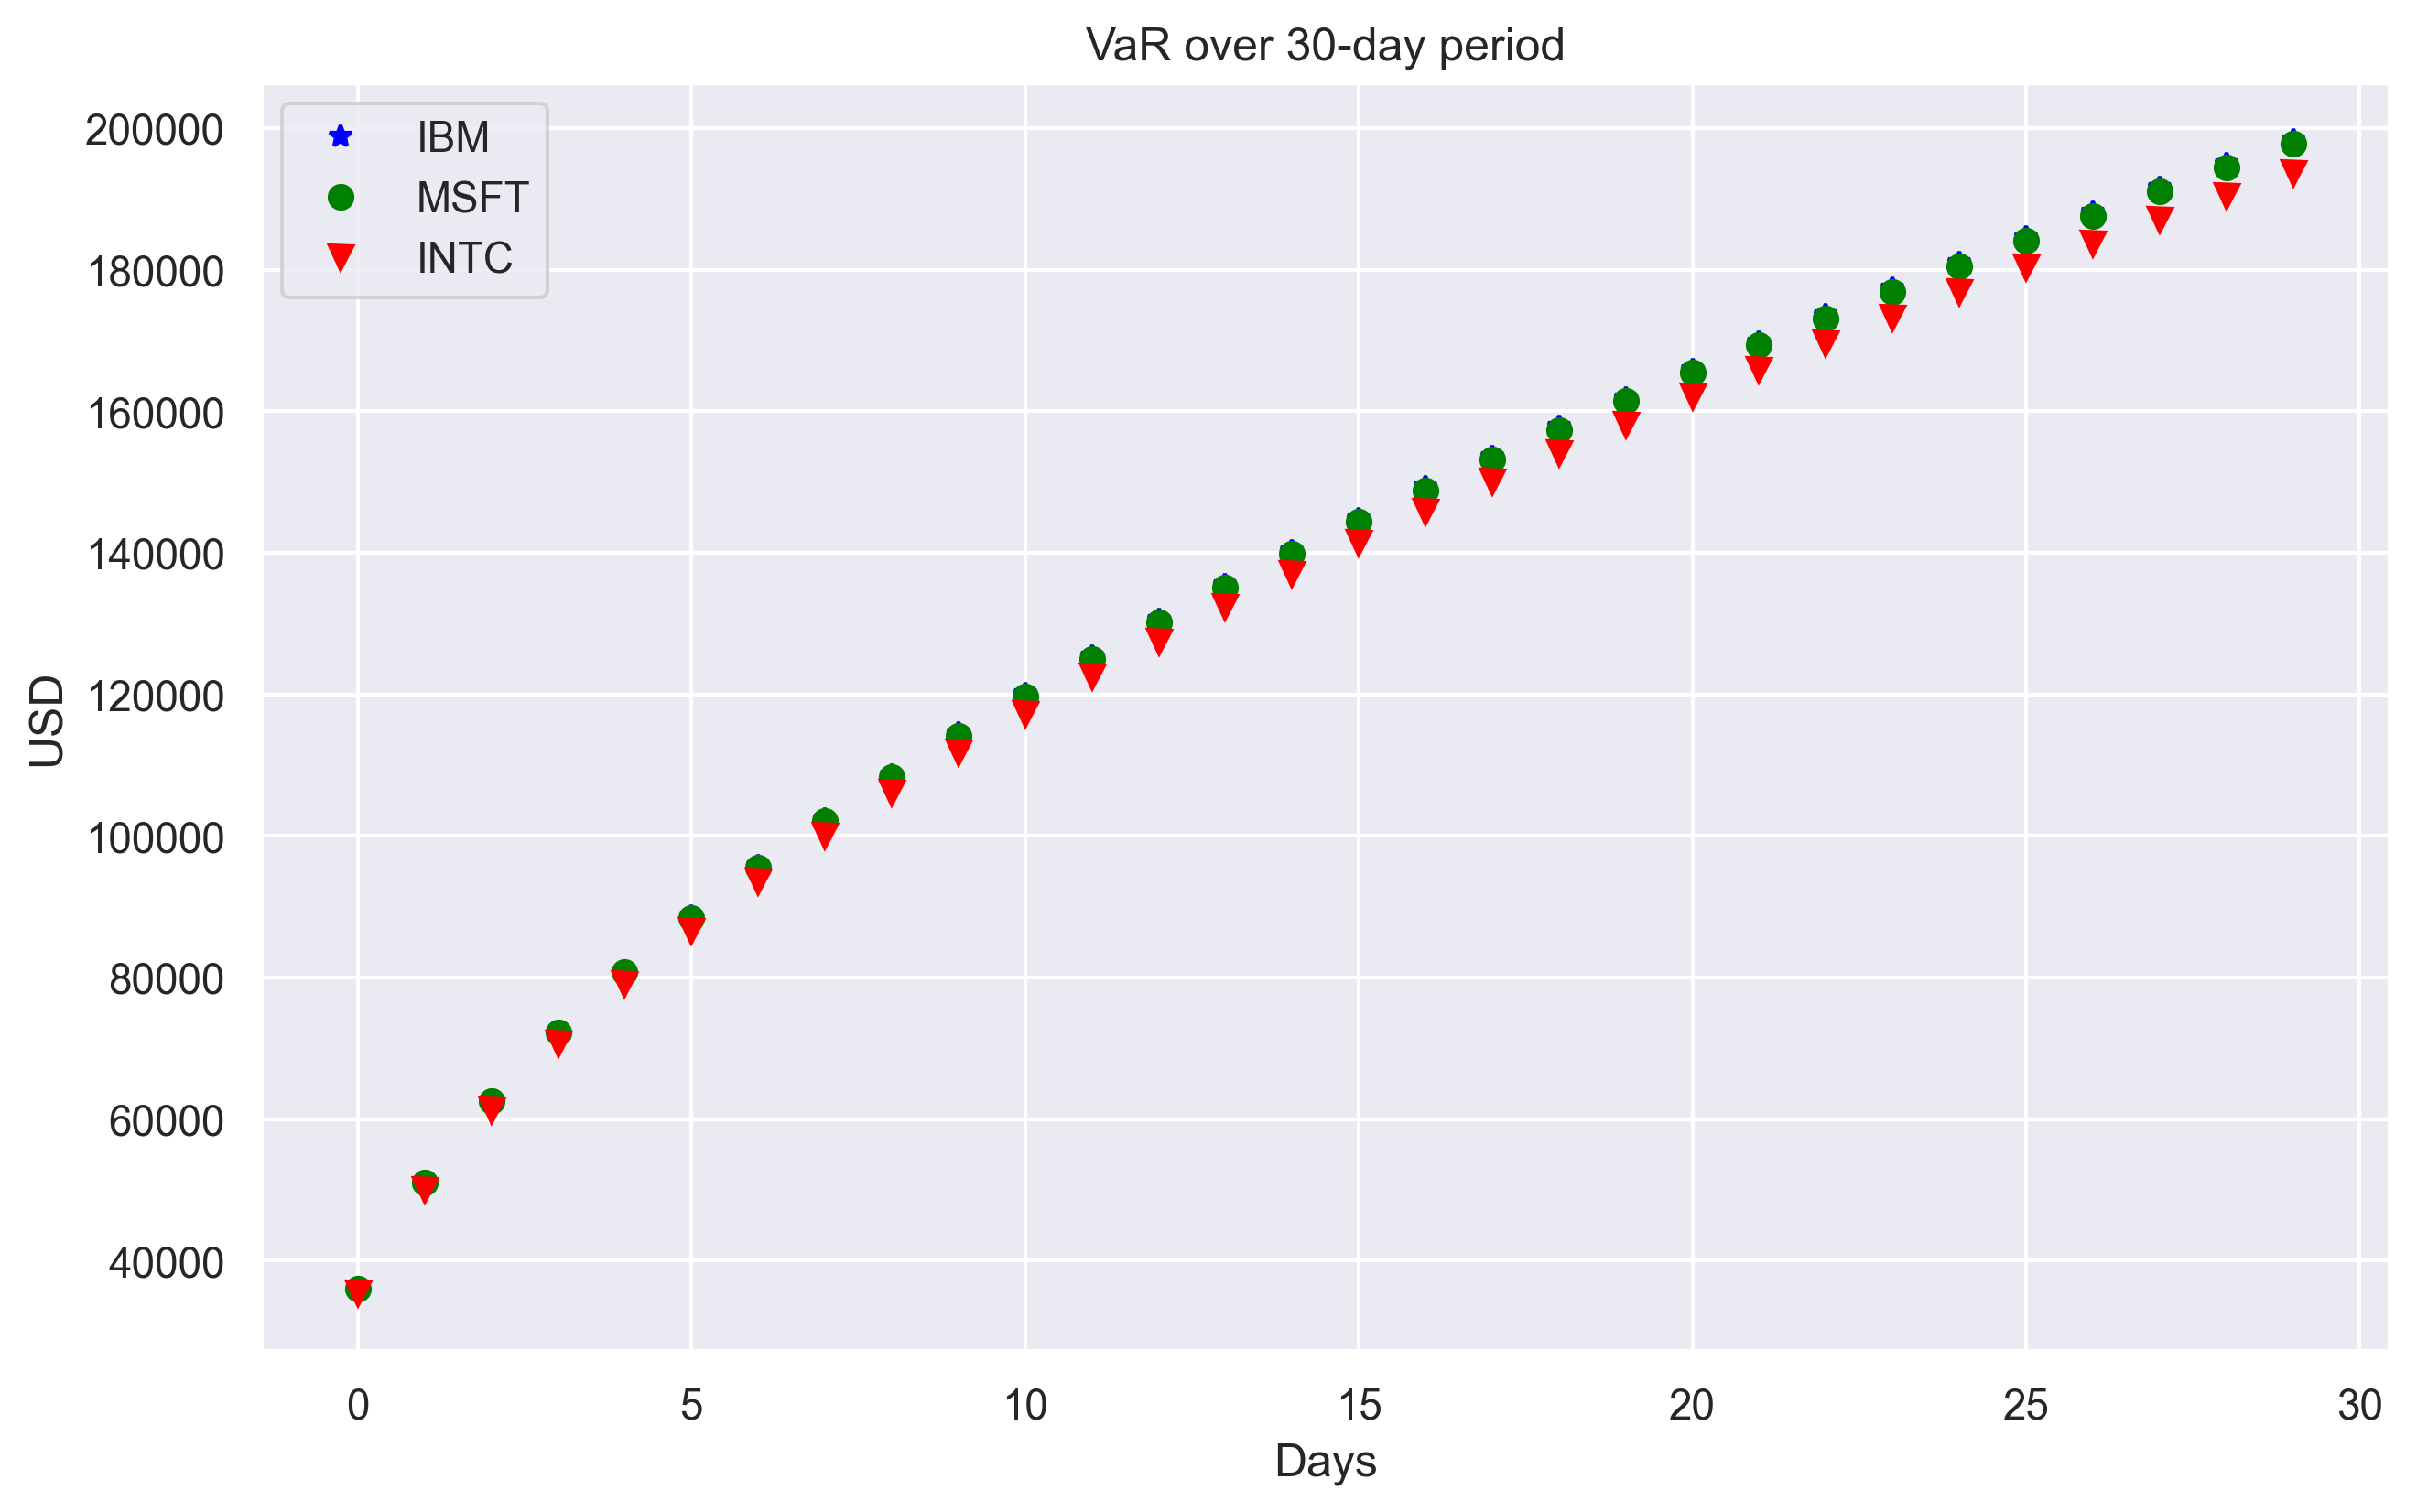

In [28]:
var_horizon = []
time_horizon = 30
for j in range(len(stocks_returns.columns)):
    for i in range(1, time_horizon + 1):
        var_horizon.append(VaR_param[j] * np.sqrt(i))
plt.plot(var_horizon[:time_horizon], "o",
         c='blue', marker='*', label='IBM')
plt.plot(var_horizon[time_horizon:time_horizon + 30], "o",
         c='green', marker='o', label='MSFT')
plt.plot(var_horizon[time_horizon + 30:time_horizon + 60], "o",
         c='red', marker='v', label='INTC')
plt.xlabel("Days")
plt.ylabel("USD")
plt.title("VaR over 30-day period")
plt.legend()
plt.show()

## Historical Simulation VaR

In [29]:
for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
    print(np.percentile(stocks_returns.loc[:, i], 5))

-0.024917507161059404
-0.03699067114082677
-0.06289757793065523


In [30]:
stocks_returns.loc[:, 'IBM']

Date
2022-04-18   -0.003086
2022-04-19    0.023344
2022-04-20    0.068595
2022-04-21    0.011001
2022-04-22   -0.011507
                ...   
2023-04-06   -0.012489
2023-04-10    0.004053
2023-04-11   -0.004666
2023-04-12    -0.01452
2023-04-13   -0.004991
Name: IBM, Length: 249, dtype: Float64

In [31]:
np.percentile(stocks_returns.loc[:, 'IBM'], 5)

-0.024917507161059404

In [32]:
def VaR_historical(initial_investment, conf_level):
    Hist_percentile95 = []
    for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
        Hist_percentile95.append(np.percentile(stocks_returns.loc[:, i],
                                               5))
        print("Based on historical values 95% of {}'s return is {:.4f}"
              .format(i, Hist_percentile95[j]))
        VaR_historical = (initial_investment - initial_investment *
                          (1 + Hist_percentile95[j]))
        print("Historical VaR result for {} is {:.2f} "
              .format(i, VaR_historical))
        print('--' * 35)

In [33]:
VaR_historical(initial_investment,conf_level)

Based on historical values 95% of IBM's return is -0.0249
Historical VaR result for IBM is 24917.51 
----------------------------------------------------------------------
Based on historical values 95% of MSFT.O's return is -0.0370
Historical VaR result for MSFT.O is 36990.67 
----------------------------------------------------------------------
Based on historical values 95% of NVDA.O's return is -0.0629
Historical VaR result for NVDA.O is 62897.58 
----------------------------------------------------------------------


In [35]:
weights

array([0.37394996, 0.21452257, 0.41152747])

## Monte Carlo VaR

In [36]:
x = np.random.uniform(-1, 1, 100) 
y = np.random.uniform(-1, 1, 100)

In [37]:
x

array([-0.33810834,  0.11353341, -0.6296279 ,  0.9245558 , -0.99337627,
        0.10436669,  0.06346078,  0.46333068,  0.69273014,  0.57621585,
       -0.33556861,  0.98402023, -0.25779869,  0.06628072,  0.52339078,
       -0.57433207, -0.90748432,  0.00821485,  0.64287718, -0.79197016,
       -0.89531263,  0.23025303,  0.84473684,  0.41564095, -0.43147468,
        0.27775922, -0.40825789, -0.70897988, -0.92798785,  0.16212902,
        0.36139436, -0.26905605,  0.74747805,  0.73385164,  0.0992735 ,
       -0.086799  , -0.20130082, -0.43663908,  0.95941146, -0.56095466,
        0.54377018, -0.6159076 ,  0.80462468, -0.13467109, -0.10635584,
        0.44638571, -0.87090601, -0.24139391, -0.14901935,  0.95325021,
        0.3868313 ,  0.1881064 , -0.19069689,  0.38785751,  0.43720557,
        0.32622774,  0.56694349,  0.4775493 , -0.41542742, -0.33941779,
       -0.78144097, -0.9364881 , -0.76028231,  0.7184206 ,  0.59609454,
        0.39143954,  0.9686238 ,  0.18696134,  0.50024566,  0.40

In [38]:
sample = 100    
def pi_calc(x, y):
    point_inside_circle = 0
    for i in range(sample):
        if np.sqrt(x[i] ** 2 + y[i] ** 2) <= 1:
            point_inside_circle += 1 
    print('pi value is {}'.format(4 * point_inside_circle/sample))

In [39]:
pi_calc(x,y)

pi value is 3.32


In [40]:
x = np.random.uniform(-1, 1, 1000000)
y = np.random.uniform(-1, 1, 1000000)

In [47]:
x

array([ 0.84710155, -0.75082892,  0.55533765, ..., -0.00369858,
       -0.4450155 ,  0.91328085])

In [50]:
sample = 1000000   

def pi_calc(x, y):
    point_inside_circle = 0
    for i in range(sample):
        if np.sqrt(x[i] ** 2 + y[i] ** 2) < 1:
            point_inside_circle += 1 
    print('pi value is {:.2f}'.format(4 * point_inside_circle/sample))

In [51]:
pi_calc(x,y)

pi value is 3.14


In [52]:
len(stocks.columns)

3

In [41]:
sim_data = pd.DataFrame([])
num_reps = 1000
n = 100
for i in range(len(stocks.columns)):
    print(i)

0
1
2


In [42]:
sim_data = pd.DataFrame([])
num_reps = 1000
n = 100
for i in range(len(stocks.columns)):
    mean = np.random.randn(n).mean()
    std = np.random.randn(n).std()
    temp = pd.DataFrame(np.random.normal(mean, std, num_reps))
    sim_data = pd.concat([sim_data, temp], axis=1)
sim_data.columns = ['Simulation 1', 'Simulation 2', 'Simulation 3']

In [43]:
sim_data

,Simulation 1,Simulation 2,Simulation 3
0,-0.361060,0.863254,0.355566
1,-0.701333,1.109442,0.596390
2,-0.196031,-0.402176,0.548912
3,-0.811961,-0.613454,1.815826
4,-0.443499,-0.622537,0.678508
...,...,...,...
995,-0.797204,-0.784223,-0.588581
996,2.274156,-1.545279,1.671733
997,-1.852090,-0.034605,0.350481
998,-2.109982,-0.645118,-0.234002


In [44]:
MC_percentile95 = []
for i, j in zip(sim_data.columns, range(len(sim_data.columns))):
    print(i,j)

Simulation 1 0
Simulation 2 1
Simulation 3 2


In [45]:
def MC_VaR(initial_investment, conf_level):
    MC_percentile95 = []
    for i, j in zip(sim_data.columns, range(len(sim_data.columns))):
        MC_percentile95.append(np.percentile(sim_data.loc[:, i], 5))
        print("Based on simulation 95% of {}'s return is {:.4f}"
              .format(i, MC_percentile95[j]))
        VaR_MC = (initial_investment - initial_investment * 
                  (1 + MC_percentile95[j]))
        print("Simulation VaR result for {} is {:.2f} "
              .format(i, VaR_MC))
        print('--' * 35)

In [46]:
MC_VaR(initial_investment, conf_level)

Based on simulation 95% of Simulation 1's return is -1.9964
Simulation VaR result for Simulation 1 is 1996358.26 
----------------------------------------------------------------------
Based on simulation 95% of Simulation 2's return is -1.4728
Simulation VaR result for Simulation 2 is 1472832.47 
----------------------------------------------------------------------
Based on simulation 95% of Simulation 3's return is -1.2484
Simulation VaR result for Simulation 3 is 1248399.76 
----------------------------------------------------------------------
